# Aerial Semantic Segmentation

This notebook provides the data loading, augmentation, and visualization utilities for an aerial semantic segmentation task using PyTorch Lightning.

In [1]:
# --- Imports & Setup ----------------------------------------------------------
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.pyplot as plt  
import matplotlib.patches as mpatches
%matplotlib 

# PyTorch Lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar, Callback
from lightning.pytorch.loggers import TensorBoardLogger

# PyTorch & TorchMetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import MeanMetric, Metric
from torchmetrics.classification import MulticlassAccuracy, MulticlassJaccardIndex

from torchvision.models import segmentation
from torchvision import datasets, transforms
from torchvision.transforms import v2 as transformsv2
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

# Data handling
import zipfile
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from dataclasses import dataclass
from typing import Union, Optional

## Utility Functions

These helpers handle image resizing, loading, and basic preprocessing.

In [2]:
def resize_keep_aspect(
    img: Image.Image,
    image_min_size: int,
    resample=Image.Resampling.NEAREST
) -> Image.Image:
    """
    Resize an image so that its smaller side equals `image_min_size`,
    preserving the aspect ratio.

    Args:
        img: PIL Image to resize.
        image_min_size: Target size for the smaller edge.
        resample: Resampling filter to use (default: NEAREST).

    Returns:
        A resized PIL Image.
    """
    w, h = img.size
    
    scale = image_min_size / min(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return img.resize((new_w, new_h), resample=resample)

In [3]:
def load_image(
    path: str,
    image_min_size: int = 720,
    convert_to_rgb: bool = False
) -> Image.Image:
    """
    Load an image from disk, convert color space, and resize while
    preserving aspect ratio.

    Args:
        path: File path to the image (.jpg or .png).
        image_min_size: Target size for the smaller edge after resizing.
        convert_to_rgb: Whether to convert the image to RGB; otherwise
            converts to grayscale.

    Returns:
        A PIL Image after conversion and resizing.
    """
    
    img = Image.open(path)
    if convert_to_rgb:
        img = img.convert('RGB')
        img_resized = resize_keep_aspect(img, image_min_size, resample=Image.Resampling.NEAREST)
    else:
        img = img.convert("L")
        img_resized = resize_keep_aspect(img, image_min_size, resample=Image.Resampling.NEAREST)
    return img_resized

In [4]:
class SemSegDataset(Dataset):
    """
    PyTorch Dataset for semantic segmentation tasks.

    Attributes:
        images_dir: Directory with input images (.jpg).
        masks_dir: Directory with mask images (.png), or None for test-only.
        df: DataFrame of image IDs.
        transform_common: Common transforms (Tensor + Normalize).
        transform_aug_color: Color jitter transforms.
        transform_aug_jointmorph: Joint spatial transforms.
        data_aug: Flag to enable augmentations.
        image_min_size: Minimum size for resizing.
        return_image_id: Return ID instead of mask for test mode.
    """
    def __init__(
        self,
        images_dir: str,
        csv_file: str,
        transform_common: transforms.Compose,
        masks_dir: Optional[str] = None,
        transform_aug_color: Optional[transforms.Compose] = None,
        transform_aug_jointmorph: Optional[transformsv2.Compose] = None,
        image_min_size: Union[int, tuple] = (720, 720),
        return_image_id: bool = False
    ):
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        
        self.df = pd.read_csv(csv_file, dtype=str)
        self.transform_common = transform_common
        self.transform_aug_color = transform_aug_color
        self.transform_aug_jointmorph = transform_aug_jointmorph
        self.data_aug : bool = False
        self.image_min_size = image_min_size
        self.return_image_id=return_image_id

        self.ids = self.df['ImageID'].tolist()

        #Preload to RAM
        self.images = []
        self.masks = []

    def __len__(self):
        """Return the total number of samples."""
        return len(self.ids)

    def use_data_augmentation(self, on : bool = True):
        """Enable or disable data augmentations."""
        self.data_aug = on
        

    def __getitem__(self, idx):
        """
        Fetch an image-mask pair (or image & ID) and apply transforms.
        """
        img=None
        mask=None
        img_id=None

        img_id = self.ids[idx]
        img_path = os.path.join(self.images_dir, f"{img_id}.jpg")
        img = load_image(img_path, image_min_size = self.image_min_size, convert_to_rgb = True)

        # Test-only mode: return ID and image
        if self.return_image_id:
            img  = self.transform_common(img)
            return img_id, img

        # Load mask if available
        if self.masks_dir:
            mask_path = os.path.join(self.masks_dir, f"{img_id}.png")
            mask = load_image(mask_path, image_min_size = self.image_min_size, convert_to_rgb = False)
            # Joint augmentations (color + spatial)
            if self.transform_aug_jointmorph and self.data_aug:
                img  = self.transform_aug_color(img)
                img, mask = self.transform_aug_jointmorph(img, mask)
            
        img  = self.transform_common(img)
        mask_tensor = torch.tensor(np.array(mask), dtype=torch.long)
        
        return img, mask_tensor

## DataModule
`AerialSeg_DataModule` wraps training, validation, and test loaders
using PyTorch Lightning conventions.

In [5]:
class AerialSeg_DataModule(pl.LightningDataModule):
    """
    LightningDataModule for Aerial Semantic Segmentation.
    Handles data download, splitting, transforms, and DataLoaders.
    """
    def __init__(
        self,
        batch_size: int,
        num_workers: int,
        image_min_size: int = 720,
        test_csv: str = "./dataset/test.csv",
        train_csv: Optional[str] = None
    ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.set_data_augment = False
        
        self.test_csv = test_csv
        self.train_csv = train_csv
        self.val_csv = None
        self.image_min_size = image_min_size
        
        self.mean = None
        self.std  = None
        self.common_transforms=None
        self.aug_transforms=None
        self.transform_aug_jointmorph=None

        self.train_dataset=None
        self.val_dataset = None
        self.test_dataset =None

    def get_mean_and_std(self):
        """Set normalization statistics (ImageNet defaults)."""
        self.mean = [0.485, 0.456, 0.406]
        self.std =  [0.229, 0.224, 0.225]
        
    def setup_transforms(self):
        """Create common and augmentation transforms."""
        if self.mean == None or self.std == None:
            self.get_mean_and_std()
        
        self.common_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
        
        self.transform_aug_color = transforms.Compose([
                transforms.ColorJitter(
                    brightness=0.3, hue=0.15
                ),
                transforms.RandomEqualize(),
        ])

        # Preprocessing transform - Resize. Applied on load to reduce memory and time required to apply other transforms.
        self.transform_aug_jointmorph = transformsv2.Compose([
            transformsv2.RandomHorizontalFlip(p=0.5),  # :contentReference[oaicite:0]{index=0}
        
            transformsv2.RandomApply(
                torch.nn.ModuleList([
                    transformsv2.RandomAffine(
                        degrees=(-10, 10),
                        translate=(0.2, 0.2),
                        scale=(0.9, 1.4),
                        interpolation=transforms.InterpolationMode.NEAREST,
                        fill=0
                    )
                ]),
                p=0.95
            ),
        ])

    def prepare_data(self) -> None:
        """
        Download/unzip the dataset if needed and prepare train/val splits.
        """
        curr_dir = os.getcwd()
        print("Preparing Dataset")
        filename = os.path.join(curr_dir, r"dataset/opencv-pytorch-segmentation-project-round2.zip")
        root = curr_dir

        if os.path.exists(filename):
           print("Dataset zip found.")
        else:
           print("Dataset needs to be downloaded from kaggle first, please download the dataset and place it at: "+str(filename))
        
        with zipfile.ZipFile(filename, "r") as f:

            data_extracted = os.path.join(curr_dir, "dataset/imgs/")
            self.data_root = os.path.join(curr_dir, "dataset/")

            # if data has not been extracted already (useful when experimenting again)
            if not os.path.isdir(data_extracted):
                # extract the zipfile contents
                f.extractall(self.data_root)

        self.images_dir =  os.path.join(curr_dir, "dataset/imgs/imgs/")
        self.masks_dir  =  os.path.join(curr_dir, "dataset/masks/masks/")
        base_train_csv  =  os.path.join(curr_dir, "dataset/train.csv")
        val_file        =  os.path.join(curr_dir, "dataset/autogen_valset.csv")
        train_file      =  os.path.join(curr_dir, "dataset/autogen_trainset.csv")

        if not self.train_csv:
            if not os.path.exists(train_file) or not os.path.exists(val_file):
                #Devide the train_csv in two files with randomly 80% on a train file and the other 20% in a validation file.
                #Read original train CSV 
                df = pd.read_csv(base_train_csv, dtype=str)
                #Shuffle and separate 80/20
                train_df = df.sample(frac=0.81, random_state=42)
                val_df   = df.drop(train_df.index)
                #Save splits
                train_df.to_csv(train_file, index=False)
                val_df.to_csv(val_file,   index=False)
                print(f"Split created: {len(train_df)} train / {len(val_df)} val")
            
            self.train_csv = train_file

        if not self.val_csv:
            self.val_csv=val_file
        print("Preparation completed.")
        

    def setup(self, stage=None):
        """
        Setup datasets for fit and test stages.
        """
        
        if not self.common_transforms:
            self.setup_transforms()
        if not self.train_csv:
            self.prepare_data()
        
        # Fit stage: definimos train y val
        if stage in (None, "fit") and self.train_csv:
            self.train_dataset = SemSegDataset(
                images_dir=self.images_dir,
                masks_dir =self.masks_dir,
                csv_file=self.train_csv,
                transform_common=self.common_transforms,
                transform_aug_color=self.transform_aug_color,
                transform_aug_jointmorph = self.transform_aug_jointmorph,
                image_min_size=self.image_min_size
            )
            
            self.val_dataset = SemSegDataset(
                images_dir=self.images_dir,
                masks_dir =self.masks_dir,
                csv_file=self.val_csv,
                transform_common=self.common_transforms,
                image_min_size=self.image_min_size
            )

        if stage in (None,"test") and self.test_csv:
            self.test_dataset = SemSegDataset(
                images_dir=self.images_dir,
                csv_file=self.test_csv,
                transform_common=self.common_transforms,
                image_min_size=self.image_min_size,
                return_image_id=True
            )
        
    
    def set_data_augmentation(self, on: bool = True) -> None:
        """Toggle augmentations during training."""
        self.set_data_augment = on

    def train_dataloader(self) -> DataLoader:
        """Training DataLoader with optional augmentations."""
        if self.train_dataset is None:
            return None
        self.train_dataset.use_data_augmentation(self.set_data_augment)
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self) -> DataLoader:
        """Validation DataLoader."""
        if self.val_dataset is None:
            return None
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        """Test DataLoader returning (id, image)."""
        if self.test_dataset is None:
            return None
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [6]:
data_module = AerialSeg_DataModule(batch_size=16, num_workers=4, image_min_size=720, test_csv="./dataset/test.csv")
data_module.setup()

Preparing Dataset
Dataset zip found.
Preparation completed.


## Visualization Utilities
Functions to map labels to colors and display random samples.

In [7]:
# Colormap: label index → (RGB tuple, class name)
idmap = {
    0:  (( 28,  49,  68), "Background"  ),  #
    1:  ((241,  91, 181), "Person"      ),  #
    2:  (( 220,  0, 115), "Bike"        ),  #
    3:  (( 220,  0, 115), "Car"         ),  #
    4:  ((252, 234, 222), "Drone"       ),  #
    5:  ((  0, 245, 212), "Boat"        ),  #
    6:  (( 94,  74, 227), "Animal"      ),  #
    7:  ((208,   0,   0), "Obstacle"    ),  #
    8:  ((255, 186,   8), "Construction"),  #
    9:  (( 81, 203,  32), "Vegetation"  ),  #
    10: ((162, 174, 187), "Road"        ),  #
    11: ((  0, 187, 249), "Sky"         ),  #
}

In [ ]:
def num_to_rgb(mask: np.ndarray, color_map: dict) -> np.ndarray:
    """
    Convert a single-channel mask (H×W) to an RGB image using a color map.

    Args:
        mask: 2D numpy array of class indices.
        color_map: Dict mapping index to (RGB tuple, class name).

    Returns:
        RGB image as uint8 numpy array of shape (H, W, 3).
    """
    single_layer = np.squeeze(mask)
    H, W = single_layer.shape

    output = np.zeros((H, W, 3), dtype=np.uint8)
    
    for k, (RGB, _classname) in color_map.items():
        output[single_layer == k] = RGB

    return output

def denormalize(
    tensor: torch.Tensor,
    mean: list = [0.485, 0.456, 0.406],
    std: list = [0.229, 0.224, 0.225]
) -> torch.Tensor:
    """
    Undo normalization on an image tensor.

    Args:
        tensor: 3×H×W tensor normalized with given mean/std.
        mean: List of channel means.
        std: List of channel stds.

    Returns:
        Denormalized tensor clamped to [0,1].
    """

    for c in range(3):
        tensor[c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensor, min=0.0, max=1.0)

In [9]:
def show_random_samples(
    data_module: AerialSeg_DataModule,
    color_map: dict,
    num_images: int = 3,
    data_augmentation: bool = False
) -> None:
    """
    Display random image-mask pairs from the training set.

    Args:
        data_module: Initialized AerialSeg_DataModule.
        color_map: Label → (RGB, name) mapping.
        num_images: Number of samples to show.
        data_augmentation: Whether to apply augmentations.
    """
    
    dataset = data_module.train_dataset
    dataset_length = len(dataset)
    dataset.use_data_augmentation(data_augmentation)
    
    # 1) Create legend patches
    legend_handles = []
    for _, (rgb, class_name) in color_map.items():
        color = np.array(rgb) / 255.0
        patch = mpatches.Patch(color=color, label=class_name)
        legend_handles.append(patch)
    
    # 2) Set up the figure
    total_height = 4 * num_images + 1
    plt.style.use("default")
    fig = plt.figure(figsize=(15, total_height))
    
    # 3) Add the legend at the top
    fig.legend(
        handles=legend_handles,
        loc="upper center",
        ncol=4,
        frameon=True,
        fontsize="medium"
    )
    plt.subplots_adjust(top=0.95)
    
    # 4) Display random samples
    for i in range(num_images):
        idx = random.randint(0, dataset_length - 1)
        image_tensor, mask_tensor = dataset[idx]  # image: [C, H, W], mask: [H, W]
    
        # Convert mask to RGB
        mask_np = mask_tensor.numpy()
        rgb_mask = num_to_rgb(mask_np, color_map)
    
        # Denormalize the image
        image_tensor = denormalize(image_tensor, mean=data_module.mean, std=data_module.std)
    
        # Show the image
        ax_img = plt.subplot(num_images, 2, 2 * i + 1)
        pil_image = transforms.functional.to_pil_image(image_tensor)
        ax_img.imshow(pil_image)
        ax_img.set_title("Image")
        ax_img.axis("off")
    
        # Show the mask
        ax_mask = plt.subplot(num_images, 2, 2 * i + 2)
        if rgb_mask.dtype != np.uint8:
            rgb_mask_disp = (rgb_mask * 255).astype(np.uint8)
        else:
            rgb_mask_disp = rgb_mask
        ax_mask.imshow(Image.fromarray(rgb_mask_disp))
        ax_mask.set_title("Mask")
        ax_mask.axis("off")
    
    plt.show()

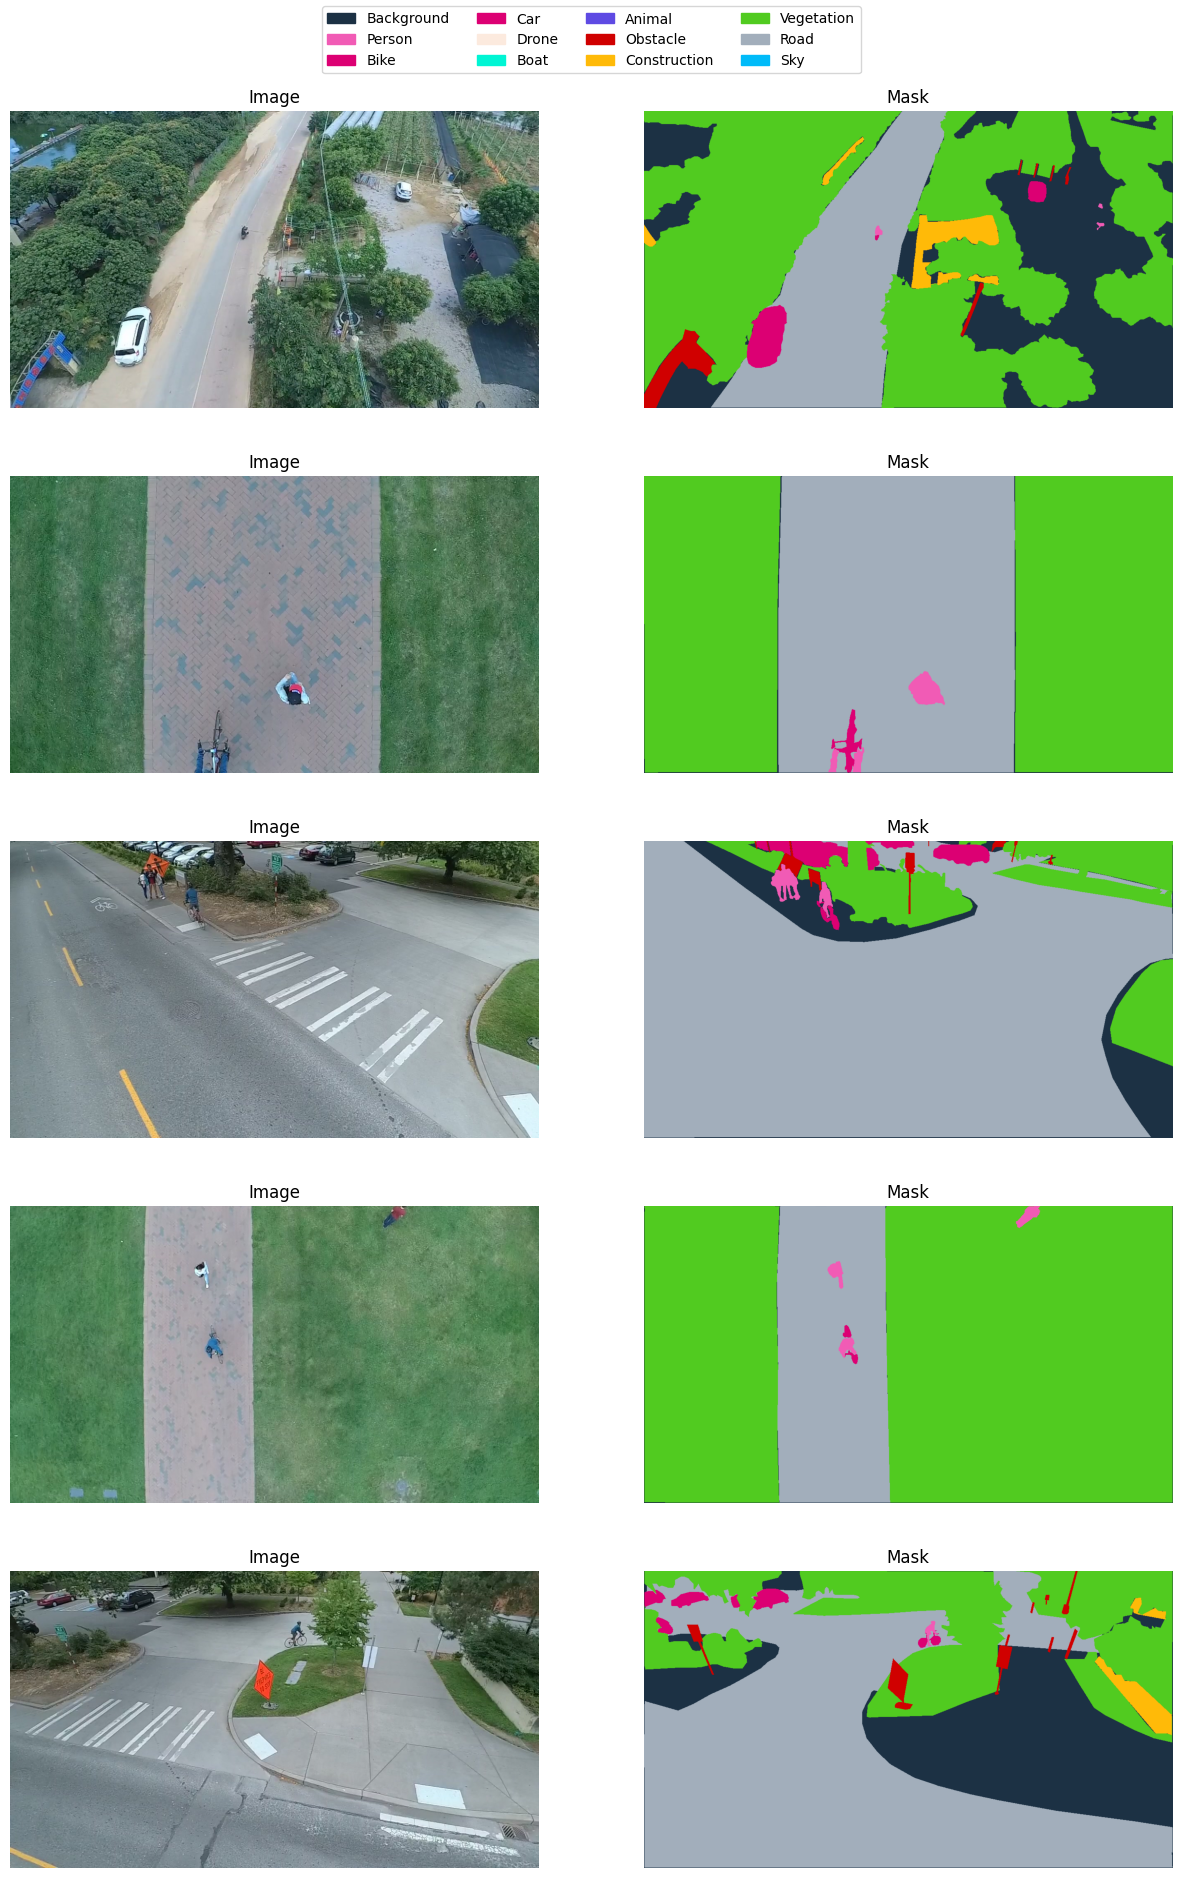

In [10]:
show_random_samples(data_module, idmap, num_images=5)

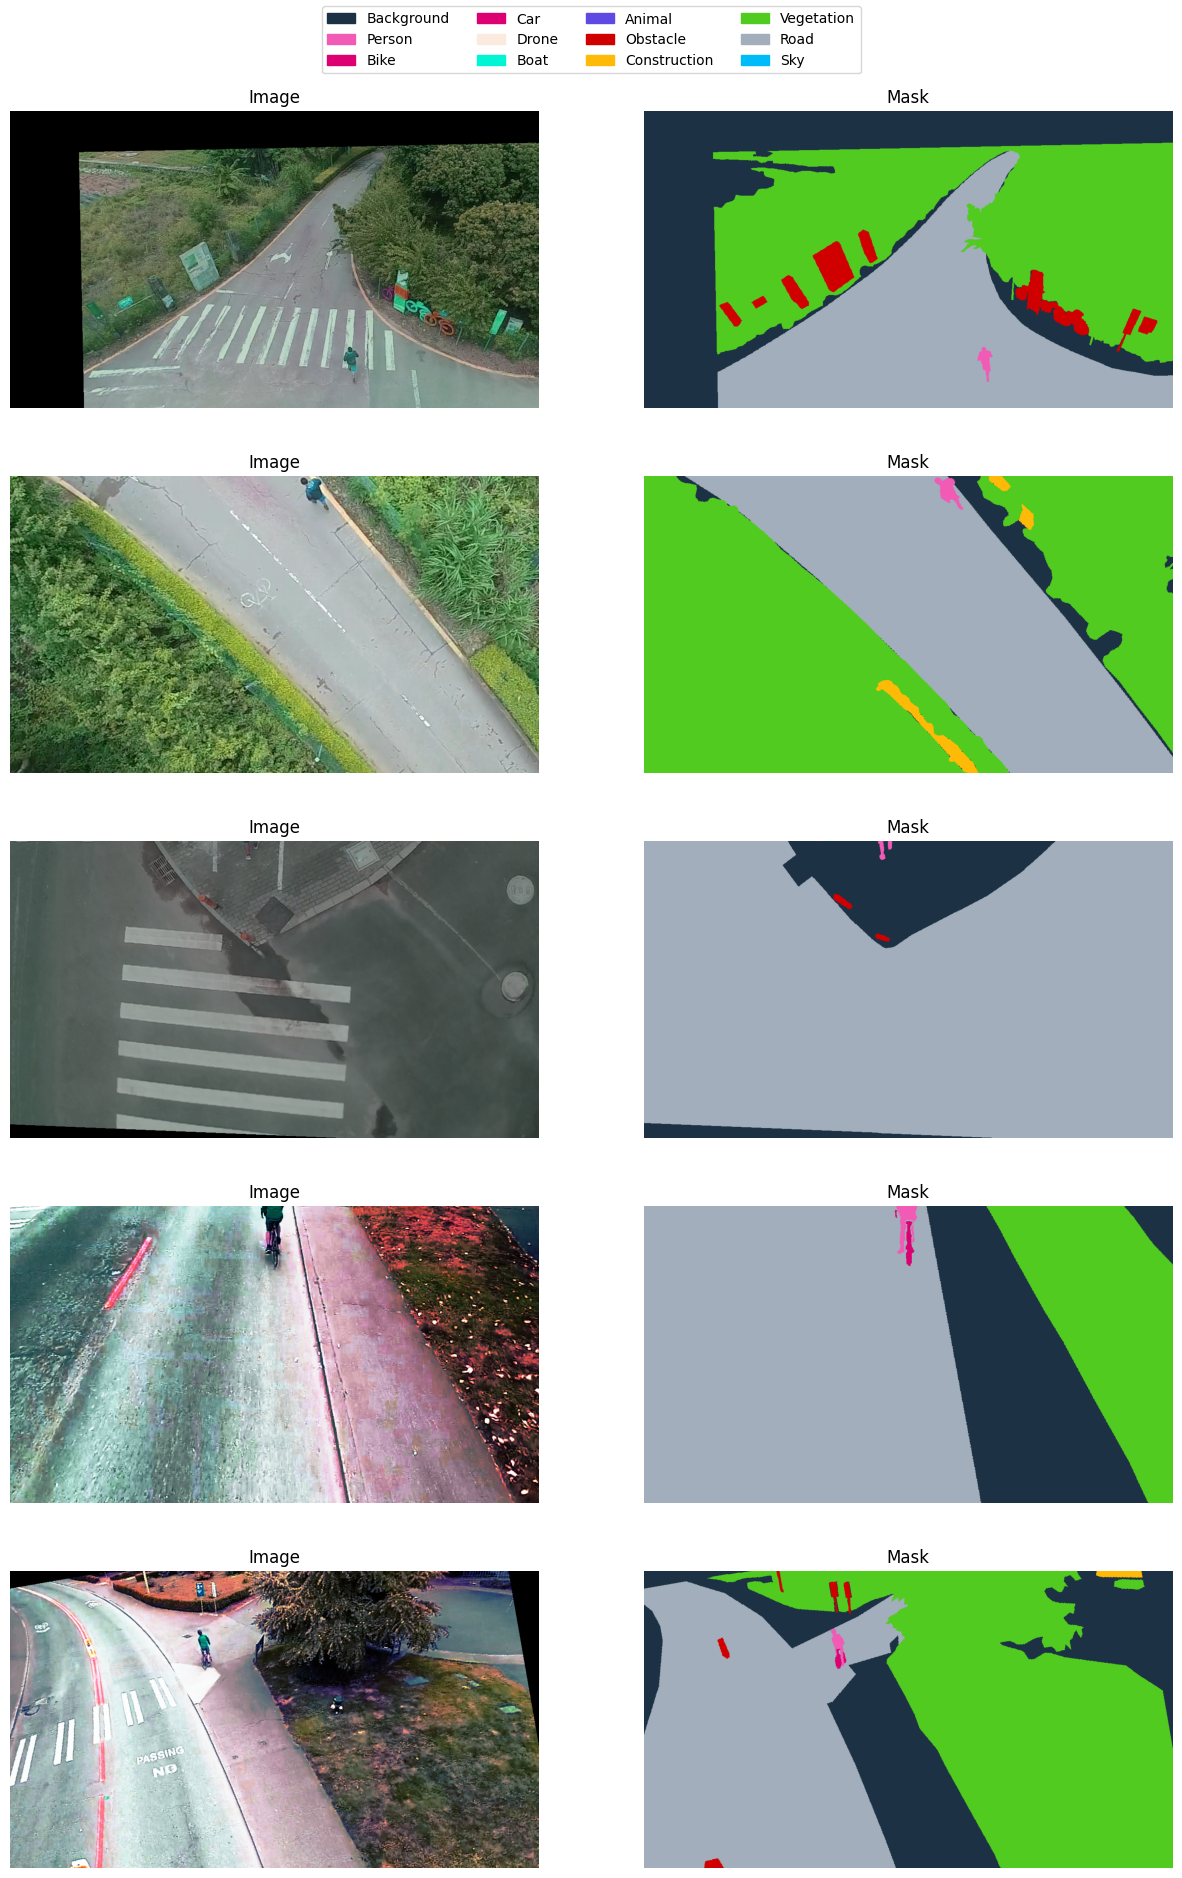

In [11]:
show_random_samples(data_module, idmap, num_images=5, data_augmentation=True)

# Evaluation Metrics
We define two custom metrics:

1. **DiceCrossEntropyLoss**: combines soft Dice loss with a weighted Cross‑Entropy term.  
2. **MulticlassDiceScore**: a PyTorch‑Metrics `Metric` computing per‑class Dice and then averaging.


In [12]:
class DiceCrossEntropyLoss(nn.Module):
    """
    Combined Dice + Cross‑Entropy loss for semantic segmentation.

    Args:
        class_weights (Optional[torch.Tensor]): Weight for each class in CE.
        num_classes (int): Number of segmentation labels.
        dims (tuple[int, ...]): Axes over which to compute Dice (default=(1,2)).
        smooth (float): Small constant to avoid zero division.
    """
    def __init__(
        self,
        class_weights: Optional[torch.Tensor] = None,
        num_classes: int = 12,
        dims: tuple = (1, 2),
        smooth: float = 1e-8
    ):
        super().__init__()
        self.class_weights = class_weights
        self.num_classes = num_classes
        self.dims = dims
        self.smooth = smooth
        if class_weights != None:
           self.CrossEntropy = nn.CrossEntropyLoss(weight=class_weights)
        else:
           self.CrossEntropy = nn.CrossEntropyLoss()

    def forward(
        self,
        predictions: torch.Tensor,
        ground_truths: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute combined Dice + CE loss.

        Args:
            predictions: [B, C, H, W] raw logits.
            ground_truths: [B, H, W] integer class labels.

        Returns:
            Scalar tensor: dice_loss + ce_loss.
        """
        # one‑hot encode targets → [B, H, W, C]
        gt_hot = F.one_hot(ground_truths, num_classes=self.num_classes).float()
        # softmax & permute → [B, H, W, C]
        pred_soft = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)

        # intersection & union for Dice
        intersection = (pred_soft * gt_hot).sum(dim=self.dims)
        summation = (pred_soft.sum(dim=self.dims) + gt_hot.sum(dim=self.dims))
        dice = (2.0 * intersection + self.smooth) / (summation + self.smooth)
        dice_loss = 1.0 - dice.mean()

        # cross‑entropy
        ce_loss = self.CrossEntropy(predictions, ground_truths)
        return dice_loss + ce_loss

In [13]:
class MulticlassDiceScore(Metric):
    """
    Per‑class Dice Score metric for multiclass segmentation.

    Args:
        num_classes (int): Total number of classes.
        ignore_index (Optional[int]): Class index to skip.
        average (str): 'macro' for mean over classes, 'none' for per‑class.
        dist_sync_on_step (bool): Sync states across GPUs each step.
    """
    def __init__(
        self,
        num_classes: int,
        ignore_index: int | None = None,
        average: str = 'macro',
        dist_sync_on_step: bool = False,
    ):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.average = average

         # State: per‑class accumulators
        self.add_state("intersections",
                       default=torch.zeros(num_classes, dtype=torch.float64),
                       dist_reduce_fx="sum")
        self.add_state("preds_sum",
                       default=torch.zeros(num_classes, dtype=torch.float64),
                       dist_reduce_fx="sum")
        self.add_state("targets_sum",
                       default=torch.zeros(num_classes, dtype=torch.float64),
                       dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        """
        Update accumulators.

        Args:
            preds: [B, H, W] predicted class indices.
            targets: [B, H, W] true class indices.
        """
        for cls in range(self.num_classes):
            if cls == self.ignore_index:
                continue
            mask_pred = preds == cls
            mask_tgt  = targets == cls
            self.intersections[cls] += torch.logical_and(mask_pred, mask_tgt).sum()
            self.preds_sum[cls]     += mask_pred.sum()
            self.targets_sum[cls]   += mask_tgt.sum()

    def compute(self) -> torch.Tensor:
        """
        Compute Dice score.

        Returns:
            If average='macro': scalar mean over classes.
            If average='none': tensor of shape [num_valid_classes].
        """
        dice_per_class = []
        for cls in range(self.num_classes):
            if cls == self.ignore_index:
                continue

            inter = self.intersections[cls]
            psum  = self.preds_sum[cls]
            tsum  = self.targets_sum[cls]
            denom = psum + tsum

            if denom == 0:
                # If class never appears, treat as perfect
                dice = torch.ones(
                    (), 
                    dtype=self.intersections.dtype, 
                    device=self.intersections.device
                )
            else:
                dice = 2 * inter / denom

            dice_per_class.append(dice)

        dice_per_class = torch.stack(dice_per_class)
        if self.average == 'macro':
            return dice_per_class.mean()
        elif self.average == 'none':
            return dice_per_class
        else:
            raise ValueError(f"Average '{self.average}' not supported")

## Model Configuration & Lightning Module

Define dataclasses for configs, set up tensor‑core precision, and build a LightningModule
using a pre‑trained DeepLabV3 backbone with fine‑tuning.

In [14]:
@dataclass(frozen=True)
class DataConfiguration:
    """Paths and DataLoader params."""
    data_root: str = "./dataset"
    num_workers: int = 4
    batch_size: int = 16

In [15]:
@dataclass
class TrainingConfiguration:
    """
    Training hyperparameters.
    - epochs: total number of training epochs.
    - data_augmentation: enable augmentations in DataModule.
    - learning_rate: initial LR for optimizer.
    - fine_tune_start: layer‑group index to unfreeze from.
    - precision: '16-mixed' or '32'.
    - patience: for early stopping.
    - load_from: checkpoint tag to resume from.
    - image_min_size: resize target.
    - class_weights: optional tensor for loss.
    """
    epochs: int = 10
    data_augmentation: bool = False
    learning_rate: float = 2e-2
    fine_tune_start: int = 99
    precision: str = "16-mixed"
    patience: int = 5
    load_from: str = "last"
    image_min_size: int = 720
    class_weights: Optional[torch.Tensor] = None

In [16]:
@dataclass
class ModelConfiguration:
    """Model architecture settings."""
    model_name: str = "deeplabv3_mobilenet_v3_large"
    use_pretrained: bool = True
    aux_loss: bool = True
    aux_weight: float = 0.5
    num_classes: int = 12

In [17]:
# Instantiate configs
data_config = DataConfiguration()
train_config = TrainingConfiguration()
model_config = ModelConfiguration()

# Use tensor‑core precision if requested
if "16" in train_config.precision:
    torch.set_float32_matmul_precision("medium")
    print("Using medium precision for tensor cores")
else:
    torch.set_float32_matmul_precision("high")
    print("Using high precision")

set_float32_matmul_precision(medium)


# Lightning Module: TransferLearningWithDeepLabV3

- Loads a pre‑trained DeepLabV3.
- Replaces classifier heads to match `num_classes`.
- Freezes backbone except last N groups.
- Logs loss, accuracy, IoU, and Dice for train/val.

In [18]:
class TransferLearningWithDeepLabV3(pl.LightningModule):
    """
    LightningModule for fine‑tuning DeepLabV3 on the dataset.

    """
    def __init__(
        self,
        model_name        = "deeplabv3_mobilenet_v3_large",  # <- cambia aquí
        use_pretrained    = True,
        fine_tune_start   = 99,
        learning_rate     = 0.01,
        num_classes       = 12,
        data_augmentation = False,
        epochs            = 1,
        aux_loss          = True,
        aux_weight        = 0.5,
        load_from         = "Just Init",
        class_weights: torch.FloatTensor = None,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Load model
        WEIGHTS = "DEFAULT" if self.hparams.use_pretrained else None
        model_fn = getattr(segmentation, self.hparams.model_name.lower())
        if not self.hparams.aux_loss:
            WEIGHTS=None
        model = model_fn(weights=WEIGHTS, aux_loss=self.hparams.aux_loss)

        
        for p in model.parameters():
            p.requires_grad = False

        cls_in = model.classifier[-1].in_channels
        model.classifier[-1] = nn.Conv2d(cls_in, self.hparams.num_classes, kernel_size=1)
        if self.hparams.aux_loss:
            aux_in = model.aux_classifier[-1].in_channels
            model.aux_classifier[-1] = nn.Conv2d(aux_in, self.hparams.num_classes, kernel_size=1)
        else:
            model.aux_classifier = None


        seq = []

        group = [model.classifier[-1]]
        if self.hparams.aux_loss:
            group.append(model.aux_classifier[-1])
        seq.append(group)

        for layer in list(model.classifier.children())[-2::-1]:
            seq.append([layer])
        

        backbone = model.backbone
        
        features = list(backbone._modules.values())
        for layer in reversed(features):
            seq.append([layer])

        # Unfreeze last layers starting at `fine_tune_start`
        total_steps = len(seq)
        start_idx = min(max(self.hparams.fine_tune_start, 0), total_steps)
        steps_to_unfreeze = total_steps - start_idx
        for i in range(steps_to_unfreeze):
            for module in seq[i]:
                for p in module.parameters():
                    p.requires_grad = True


        self.model = model
    
        self.criterion = DiceCrossEntropyLoss(
            class_weights=self.hparams.class_weights,
            num_classes=self.hparams.num_classes
        )
        self.example_input_array = torch.zeros(1, 3, 720, 720)
        
        

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.mean_train_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.mean_train_dice = MulticlassDiceScore(num_classes=num_classes, average='macro')
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.mean_valid_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.mean_valid_dice = MulticlassDiceScore(num_classes=num_classes, average='macro')
        
        
    def forward(self, x):

        return self.model(x)


    def training_step(self, batch, *args, **kwargs):

        # get data and labels from batch
        data, target = batch

        # get prediction
        output_dict = self(data)
        cls_out = output_dict['out']

        # calculate batch loss
        loss = self.criterion(cls_out, target)

        if self.hparams.aux_loss:
            aux_out = output_dict['aux'] # Auxiliary head output
            # Calculate simple cross entropy loss for auxiliary head output.
            aux_loss = F.cross_entropy(aux_out, target)

            # A weighted combination between classifier and auxiliary head loss.
            loss += self.hparams.aux_weight * aux_loss

        # Batch Predictions.
        pred_batch = cls_out.detach().argmax(dim=1)

        self.mean_train_loss(loss)
        self.mean_train_acc(pred_batch, target)
        self.mean_train_iou(pred_batch, target)
        self.mean_train_dice(pred_batch, target)

        # Arguments such as on_epoch, on_step and logger are set automatically depending on
        # hook methods it's been called from
        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)

        # logging and adding current batch_acc to progress_bar
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)

        # logging and adding current batch_iou to progress_bar
        self.log("train/batch_iou", self.mean_train_iou, prog_bar=True, logger=True)

        # logging and adding current batch_iou to progress_bar
        self.log("train/batch_dice", self.mean_train_dice, prog_bar=True, logger=True)

        return loss

    
    def on_train_epoch_end(self):
        train_iou = self.mean_train_iou.compute()
        self.log("train/iou", train_iou, prog_bar=True, logger=True)
        
        train_loss = self.mean_train_loss.compute()
        self.log("train/loss", train_loss, prog_bar=True, logger=True)

        train_acc = self.mean_train_acc.compute()
        self.log("train/acc", train_acc, prog_bar=True, logger=True)

        train_dice = self.mean_train_dice.compute()
        self.log("train/dice", train_dice, prog_bar=True, logger=True)

        self.log("step", self.current_epoch, logger=True)

        self.mean_train_iou.reset()
        self.mean_train_loss.reset()
        self.mean_train_acc.reset()
        self.mean_train_dice.reset()

    
    def validation_step(self, batch, *args, **kwargs):

        # get data and labels from batch
        data, target = batch

        # get prediction
        output = (self(data))['out']

        # calculate loss
        loss = self.criterion(output, target)

        # Batch Predictions.
        pred_batch = output.argmax(dim=1)

        # Update logs.
        self.mean_valid_loss(loss, weight=data.shape[0])
        self.mean_valid_acc(pred_batch, target)
        self.mean_valid_iou(pred_batch, target)
        self.mean_valid_dice(pred_batch, target)
        

    def on_validation_epoch_end(self):
        valid_iou = self.mean_valid_iou.compute()
        self.log("valid/iou", valid_iou, prog_bar=True, logger=True)

        valid_loss = self.mean_valid_loss.compute()
        self.log("valid/loss", valid_loss, prog_bar=True, logger=True)

        valid_acc = self.mean_valid_acc.compute()
        self.log("valid/acc", valid_acc, prog_bar=True, logger=True)

        valid_dice = self.mean_valid_dice.compute()
        self.log("valid/dice", valid_dice, prog_bar=True, logger=True)
        
        self.log("step", self.current_epoch, logger=True)

        # resetea acumuladores de validación
        self.mean_valid_iou.reset()
        self.mean_valid_loss.reset()
        self.mean_valid_acc.reset()
        self.mean_valid_dice.reset()

    def configure_optimizers(self):
        trainable_params = filter(lambda p: p.requires_grad, self.parameters())
        optimizer = torch.optim.SGD(trainable_params, lr=self.hparams.learning_rate, momentum=0.9, weight_decay=1e-4)
        return optimizer

## Model Instantiation for Transfer Learning & Fine-Tuning

In [1]:
def load_model_for_TransferLearningandFT(
    data_module,
    train_config,
    model_config,
    ckpt_path=None
):
    """
    Create or restore a TransferLearningWithDeepLabV3 model.

    Args:
        data_module:      AerialSeg_DataModule, for loading train masks.
        train_config:     TrainingConfiguration, may supply class_weights.
        model_config:     ModelConfiguration, defines num_classes, model_name, etc.
        ckpt_path (str):  Optional checkpoint path to resume from.

    Returns:
        TransferLearningWithDeepLabV3: initialized or checkpoint-restored model.
    """
    class_weights = None
    # If training CSV is available, derive or fetch class weights
    if data_module.train_csv:
        if train_config.class_weights != None:
            class_weights= train_config.class_weights
        else:
            # Compute inverted frequency weights
            counts = np.zeros(model_config.num_classes, dtype=np.int64)
            total_pixels = 0
            
            train_loader = data_module.train_dataloader()
            for _, masks in train_loader:
                flat = masks.view(-1).cpu().numpy()
                counts_batch = np.bincount(flat, minlength=model_config.num_classes)
                counts += counts_batch
                total_pixels += flat.size
            
           # Avoid zeros and compute: total / (num_classes * class_count)
            counts = np.where(counts == 0, 1, counts)
            weights = total_pixels / (model_config.num_classes * counts)
            class_weights = torch.tensor(weights, dtype=torch.float32)
            
    # Instantiate or load-from-checkpoint    
    if not ckpt_path:
        model = TransferLearningWithDeepLabV3(
            model_name    =model_config.model_name,
            use_pretrained=model_config.use_pretrained,
            fine_tune_start=train_config.fine_tune_start,
            num_classes=model_config.num_classes,
            learning_rate=train_config.learning_rate,
            data_augmentation =train_config.data_augmentation,
            epochs = train_config.epochs,
            aux_loss = model_config.aux_loss,
            aux_weight=model_config.aux_weight,
            class_weights=class_weights
        )
    else:
        model = TransferLearningWithDeepLabV3.load_from_checkpoint(
            ckpt_path,
            strict=False,  # ignore missing keys
            model_name     =model_config.model_name,
            use_pretrained =model_config.use_pretrained,
            fine_tune_start=train_config.fine_tune_start,
            learning_rate  =train_config.learning_rate,
            data_augmentation =train_config.data_augmentation,
            epochs = train_config.epochs,
            load_from = train_config.load_from,
            aux_loss = model_config.aux_loss,
            aux_weight=model_config.aux_weight,
            class_weights=class_weights
        )
        
    return model

In [20]:
#model = load_model_for_TransferLearningandFT(data_module, train_config, model_config)
#print(model)

## Custom Callbacks: Progress Bar & In-Memory Checkpointing

- **ProgressBarLeave:** keeps the progress bar on-screen after each epoch.  
- **InMemoryCheckpoint:** tracks best/last weights in memory and periodically writes snapshots.

In [21]:
class ProgressBarLeave(RichProgressBar):
    def __init__(self, refresh_rate=1, console_kwargs=None):
        """
        Rich progress bar that persists at the end of training.
        """
        super().__init__(
            refresh_rate=refresh_rate,
            leave=True,
            #theme=theme,
            console_kwargs=console_kwargs
        )

In [22]:
class InMemoryCheckpoint(Callback):
    """
    Callback that retains best/last model state in memory and
    dumps to disk every 5 epochs (and at train end).

    Args:
        dirpath (str): base directory for checkpoint files.
        monitor (str): metric to monitor (e.g. 'valid/loss').
        mode (str): 'min' or 'max' to determine improvement.
    """
    def __init__(self, dirpath: str, monitor: str = 'valid/loss', mode: str = 'min'):
        super().__init__()
        self.dirpath = dirpath
        self.monitor = monitor
        self.mode = mode

        self.best_score = None
        self.best_state = None
        self.last_state = None

        self.best_epoch = -1

        self.best_model_path = None
        self.last_model_path = None

    def on_validation_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        metrics = trainer.callback_metrics
        current = metrics.get(self.monitor)
        if current is None:
            return

        is_better = (self.best_score is None) or \
            (self.mode == 'min' and current < self.best_score) or \
            (self.mode == 'max' and current > self.best_score)

        if is_better:
            self.best_score = float(current)
            self.best_state = {k: v.cpu().clone() for k, v in pl_module.state_dict().items()}
            self.best_epoch = trainer.current_epoch

        # Actualiza siempre el último estado
        self.last_state = {k: v.cpu().clone() for k, v in pl_module.state_dict().items()}

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        epoch = trainer.current_epoch
        # Every 5 epochs (1-based): epochs 4,9,14,... in 0-based
        if (epoch + 1) % 5 == 0:
            ckpt_dir = os.path.join(self.dirpath, 'checkpoints')
            os.makedirs(ckpt_dir, exist_ok=True)

            # Save last state
            last_path = os.path.join(ckpt_dir, f'last_epoch{epoch+1}.ckpt')
            torch.save({
                'epoch':         epoch + 1,
                'global_step':   trainer.global_step,
                'state_dict':    self.last_state,
                'optimizer_states': [],
                'lr_schedulers':    [],
                'pytorch-lightning_version': pl.__version__,
            }, last_path)
            self.last_model_path = last_path

            if epoch - self.best_epoch < 5:
                best_path = os.path.join(ckpt_dir, f'best_epoch{epoch+1}.ckpt')
                torch.save({
                    'epoch':             epoch + 1,
                    'global_step':       trainer.global_step,
                    'best_epoch':        self.best_epoch + 1,
                    'state_dict':        self.best_state,
                    'best_score':        self.best_score,
                    'optimizer_states':  [], 
                    'lr_schedulers':     [], 
                    'pytorch-lightning_version': pl.__version__,
                }, best_path)
                self.best_model_path = best_path

    def on_train_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        ckpt_dir = os.path.join(self.dirpath, 'checkpoints')
        os.makedirs(ckpt_dir, exist_ok=True)

        # Final Best
        final_best = os.path.join(ckpt_dir, 'best.ckpt')
        torch.save({
            'epoch':             trainer.current_epoch + 1,
            'global_step':       trainer.global_step,
            'best_epoch':        self.best_epoch + 1,
            'state_dict':        self.best_state,
            'best_score':        self.best_score,
            'optimizer_states':  [],
            'lr_schedulers':     [],
            'pytorch-lightning_version': pl.__version__,
        }, final_best)
        self.best_model_path = final_best

        # Final Last
        final_last = os.path.join(ckpt_dir, 'last.ckpt')
        torch.save({
            'epoch':             trainer.current_epoch + 1,
            'global_step':       trainer.global_step,
            'state_dict':        self.last_state,
            'optimizer_states':  [],
            'lr_schedulers':     [],
            'pytorch-lightning_version': pl.__version__,
        }, final_last)
        self.last_model_path = final_last

## Training & Validation Runner

`training_validation` ties together logger, data_module, model, and callbacks
to perform initial training and (optionally) resume from checkpoint.


In [23]:
def training_validation(
    tensorboard_logger,
    train_config,
    data_config,
    model_config,
    model=None,
    data_module=None,
    checkpoint_callback=None,
    class_weights=None,
    ckpt_path=None
):
    """
    Execute training with early stopping and in-memory checkpointing.

    Args:
        tensorboard_logger: TensorBoardLogger instance.
        train_config:       TrainingConfiguration.
        data_config:        DataConfiguration.
        model_config:       ModelConfiguration.
        model:              Optional pre-built LightningModule.
        data_module:        Optional AerialSeg_DataModule.
        checkpoint_callback: Optional InMemoryCheckpoint callback.
        ckpt_path:          Optional checkpoint to resume from.

    Returns:
        model, data_module, checkpoint_callback
    """
    pl.seed_everything(21, workers=True)

    if not data_module:
        data_module = AerialSeg_DataModule(batch_size=data_config.batch_size,
                                           num_workers=data_config.num_workers,
                                           image_min_size=train_config.image_min_size,
                                           test_csv="./dataset/test.csv")
        
        data_module.setup()
    if not model:
        model= load_model_for_TransferLearningandFT(data_module, train_config, model_config)

    if not checkpoint_callback:
        checkpoint_callback = InMemoryCheckpoint(
            dirpath=tensorboard_logger.log_dir,
            monitor='valid/dice',
            mode='max'
        )
    
    early_stopping_callback = EarlyStopping(monitor="valid/loss", mode="min", patience=train_config.patience) 
    min_epochs=train_config.epochs

    trainer = pl.Trainer(
                enable_checkpointing=False,       # <— disable internal ModelCheckpoint
                accelerator="auto", 
                devices="auto",  
                strategy="auto",
                logger=tensorboard_logger,
                min_epochs=min_epochs,
                precision = train_config.precision, #"16-mixed"
                callbacks=[
                    early_stopping_callback,                                                         
                    checkpoint_callback,
                    ProgressBarLeave()
                ]  
            )
    
    data_module.set_data_augmentation(train_config.data_augmentation)
    
    trainer.fit(model, data_module)

    return model, data_module, checkpoint_callback

## Launch Initial Training & Fine-Tuning

Instantiate TensorBoard loggers, run initial decoder-only training,
then update configs and resume fine-tuning from the last checkpoint.


In [ ]:
# Initial Training
tb_logger = TensorBoardLogger(
    save_dir="tb_logs",
    name="dlv3MNl_TransferLearning(LastDecoderLayer)",
    version=None
)

model, data_module, model_ckpt = training_validation(tb_logger, train_config, data_config, model_config)

In [ ]:
train_config.data_augmentation=False
train_config.learning_rate = 1e-2
train_config.fine_tune_start = 18
train_config.load_from="last"

if "last" in train_config.load_from:
    ckpt_path = model_ckpt.last_model_path
else:
    ckpt_path = model_ckpt.best_model_path

model = load_model_for_TransferLearningandFT(data_module, train_config, model_config, ckpt_path=ckpt_path)

tb_logger = TensorBoardLogger(
    save_dir="tb_logs",
    name="dlv3MNl_FineTunning(LastEncoderLayertoOutput)",
    version=None
)

model, data_module, model_ckpt = training_validation(tb_logger,
                                                     train_config, data_config, model_config, model=model,
                                                     data_module=data_module, checkpoint_callback=model_ckpt,
                                                     ckpt_path=ckpt_path)

In [ ]:
train_config.data_augmentation=True
train_config.learning_rate = 8e-3
train_config.fine_tune_start = 17
train_config.load_from="last"

if "last" in train_config.load_from:
    ckpt_path = model_ckpt.last_model_path
else:
    ckpt_path = model_ckpt.best_model_path

model = load_model_for_TransferLearningandFT(data_module, train_config, model_config, ckpt_path=ckpt_path)


tb_logger = TensorBoardLogger(
    save_dir="tb_logs",
    name="dlv3MNl_FineTunning(ASPPlayertoOutput)",
    version=None
)

model, data_module, model_ckpt  = training_validation(tb_logger,
                                                     train_config, data_config, model_config, model=model,
                                                     data_module=data_module, checkpoint_callback=model_ckpt,
                                                     ckpt_path=ckpt_path)

In [ ]:
train_config.data_augmentation=True
train_config.learning_rate = 1e-2
train_config.fine_tune_start = 8
train_config.load_from="last"


if "last" in train_config.load_from:
    ckpt_path = model_ckpt.last_model_path
else:
    ckpt_path = model_ckpt.best_model_path

model = load_model_for_TransferLearningandFT(data_module, train_config, model_config, ckpt_path=ckpt_path)

tb_logger = TensorBoardLogger(
    save_dir="tb_logs",
    name="dlv3MNl_FineTunning(LastHalfMobilNetLayerstoOutput)",
    version=None
)


model, data_module, model_ckpt  = training_validation(tb_logger,
                                                     train_config, data_config, model_config, model=model,
                                                     data_module=data_module, checkpoint_callback=model_ckpt,
                                                     ckpt_path=ckpt_path)

In [ ]:
train_config.data_augmentation=True
train_config.learning_rate = 4e-3
train_config.fine_tune_start = 0
train_config.load_from="last"
model_config.aux_loss = False

if "last" in train_config.load_from:
    ckpt_path = model_ckpt.last_model_path
else:
    ckpt_path = model_ckpt.best_model_path
model = load_model_for_TransferLearningandFT(data_module, train_config, model_config, ckpt_path=ckpt_path)

tb_logger = TensorBoardLogger(
    save_dir="tb_logs",
    name="dlv3MNl_FineTunning(AllLayers)",
    version=None
)


model, data_module, model_ckpt  = training_validation(tb_logger,
                                                     train_config, data_config, model_config, model=model,
                                                     data_module=data_module, checkpoint_callback=model_ckpt,
                                                     ckpt_path=ckpt_path)

## Inference Utilities

Functions to compute classic segmentation metrics (Dice, IoU, pixel accuracy) and visualize model predictions with metrics overlayed.

In [24]:
def dice_score(
    pred: torch.Tensor,
    target: torch.Tensor,
    num_classes: int = 12
) -> float:
    """
    Compute mean Dice coefficient across all classes.

    Args:
        pred:         [H, W] predicted class indices.
        target:       [H, W] ground‑truth class indices.
        num_classes:  number of classes.

    Returns:
        Mean Dice score (float).
    """
    dices = []
    for cls in range(num_classes):
        p = (pred == cls)
        t = (target == cls)
        inter = (p & t).sum().item()
        denom = p.sum().item() + t.sum().item()
        dices.append(1.0 if denom == 0 else 2 * inter / denom)
    return np.mean(dices)

def iou_score(
    pred: torch.Tensor,
    target: torch.Tensor,
    num_classes: int = 12
) -> float:
    """
    Compute mean Intersection over Union across all classes.

    Args:
        pred:         [H, W] predicted class indices.
        target:       [H, W] ground‑truth class indices.
        num_classes:  number of classes.

    Returns:
        Mean IoU score (float).
    """
    ious = []
    for cls in range(num_classes):
        p = (pred == cls)
        t = (target == cls)
        inter = (p & t).sum().item()
        union = (p | t).sum().item()
        ious.append(1.0 if union == 0 else inter / union)
    return np.mean(ious)

def pixel_accuracy(
    pred: torch.Tensor,
    target: torch.Tensor
) -> float:
    """
    Compute global pixel accuracy.

    Args:
        pred:   [H, W] predicted class indices.
        target: [H, W] ground‑truth class indices.

    Returns:
        Pixel accuracy (float).
    """
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

In [25]:
def show_predictions_with_metrics(
    data_module,
    color_map: dict,
    model: torch.nn.Module,
    num_images: int = 3
) -> None:
    """
    Select random validation samples, predict masks, compute metrics, and display.

    Args:
        data_module:  AerialSeg_DataModule with val_dataset ready.
        color_map:    mapping class_idx → (RGB tuple, class name).
        model:        trained segmentation model (LightningModule or nn.Module).
        num_images:   number of samples to show.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    dataset = data_module.val_dataset
    num_classes = len(color_map)

    # build legend patches
    legend_handles = []
    for cls_idx, (rgb, class_name) in color_map.items():
        color = np.array(rgb) / 255.0
        patch = mpatches.Patch(color=color, label=class_name)
        legend_handles.append(patch)

    total_height = 4 * num_images + 1
    fig = plt.figure(figsize=(15, total_height))
    fig.legend(handles=legend_handles, loc="upper center", ncol=4, frameon=True, fontsize="medium")
    plt.subplots_adjust(top=0.92, hspace=0.3)

    for i in range(num_images):
        idx = random.randrange(len(dataset))
        img_tensor, mask_tensor = dataset[idx]  # img: [C,H,W], mask: [H,W]

        # model prediction
        input_batch = img_tensor.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(input_batch)['out']                  # [1, num_classes, H, W]
            pred_mask = torch.argmax(out, dim=1).squeeze(0)  # [H, W]
        pred_mask_cpu = pred_mask.cpu()

        # compute metrics
        mask_cpu = mask_tensor.cpu()
        dice  = dice_score(pred_mask_cpu, mask_cpu, num_classes)
        iou   = iou_score(pred_mask_cpu, mask_cpu, num_classes)
        acc   = pixel_accuracy(pred_mask_cpu, mask_cpu)

        # convert masks to RGB
        true_rgb = num_to_rgb(mask_cpu.numpy(), color_map)
        pred_rgb = num_to_rgb(pred_mask_cpu.numpy(), color_map)
        # denormalize & to PIL
        img_denorm = denormalize(img_tensor, mean=data_module.mean, std=data_module.std)
        pil_img = transforms.functional.to_pil_image(img_denorm)

        # display
        ax1 = plt.subplot(num_images, 3, 3*i + 1)
        ax1.imshow(pil_img)
        ax1.set_title("Input")
        ax1.axis("off")

        ax2 = plt.subplot(num_images, 3, 3*i + 2)
        ax2.imshow(Image.fromarray(true_rgb))
        ax2.set_title("Ground Truth")
        ax2.axis("off")

        ax3 = plt.subplot(num_images, 3, 3*i + 3)
        ax3.imshow(Image.fromarray(pred_rgb))
        ax3.set_title(f"Prediction\nDice: {dice:.3f}, IoU: {iou:.3f}, Acc: {acc:.3f}")
        ax3.axis("off")

    plt.show()

In [26]:
ckpt_path = "./tb_logs/dlv3MNl_FineTunning(AllLayers)/version_0/checkpoints/best_epoch15.ckpt"
train_config.data_augmentation=False
train_config.fine_tune_start = 99
model_config.aux_loss = False

model = load_model_for_TransferLearningandFT(data_module, train_config, model_config, ckpt_path=ckpt_path)

MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 124416000, provided ptr: 0 size: 0


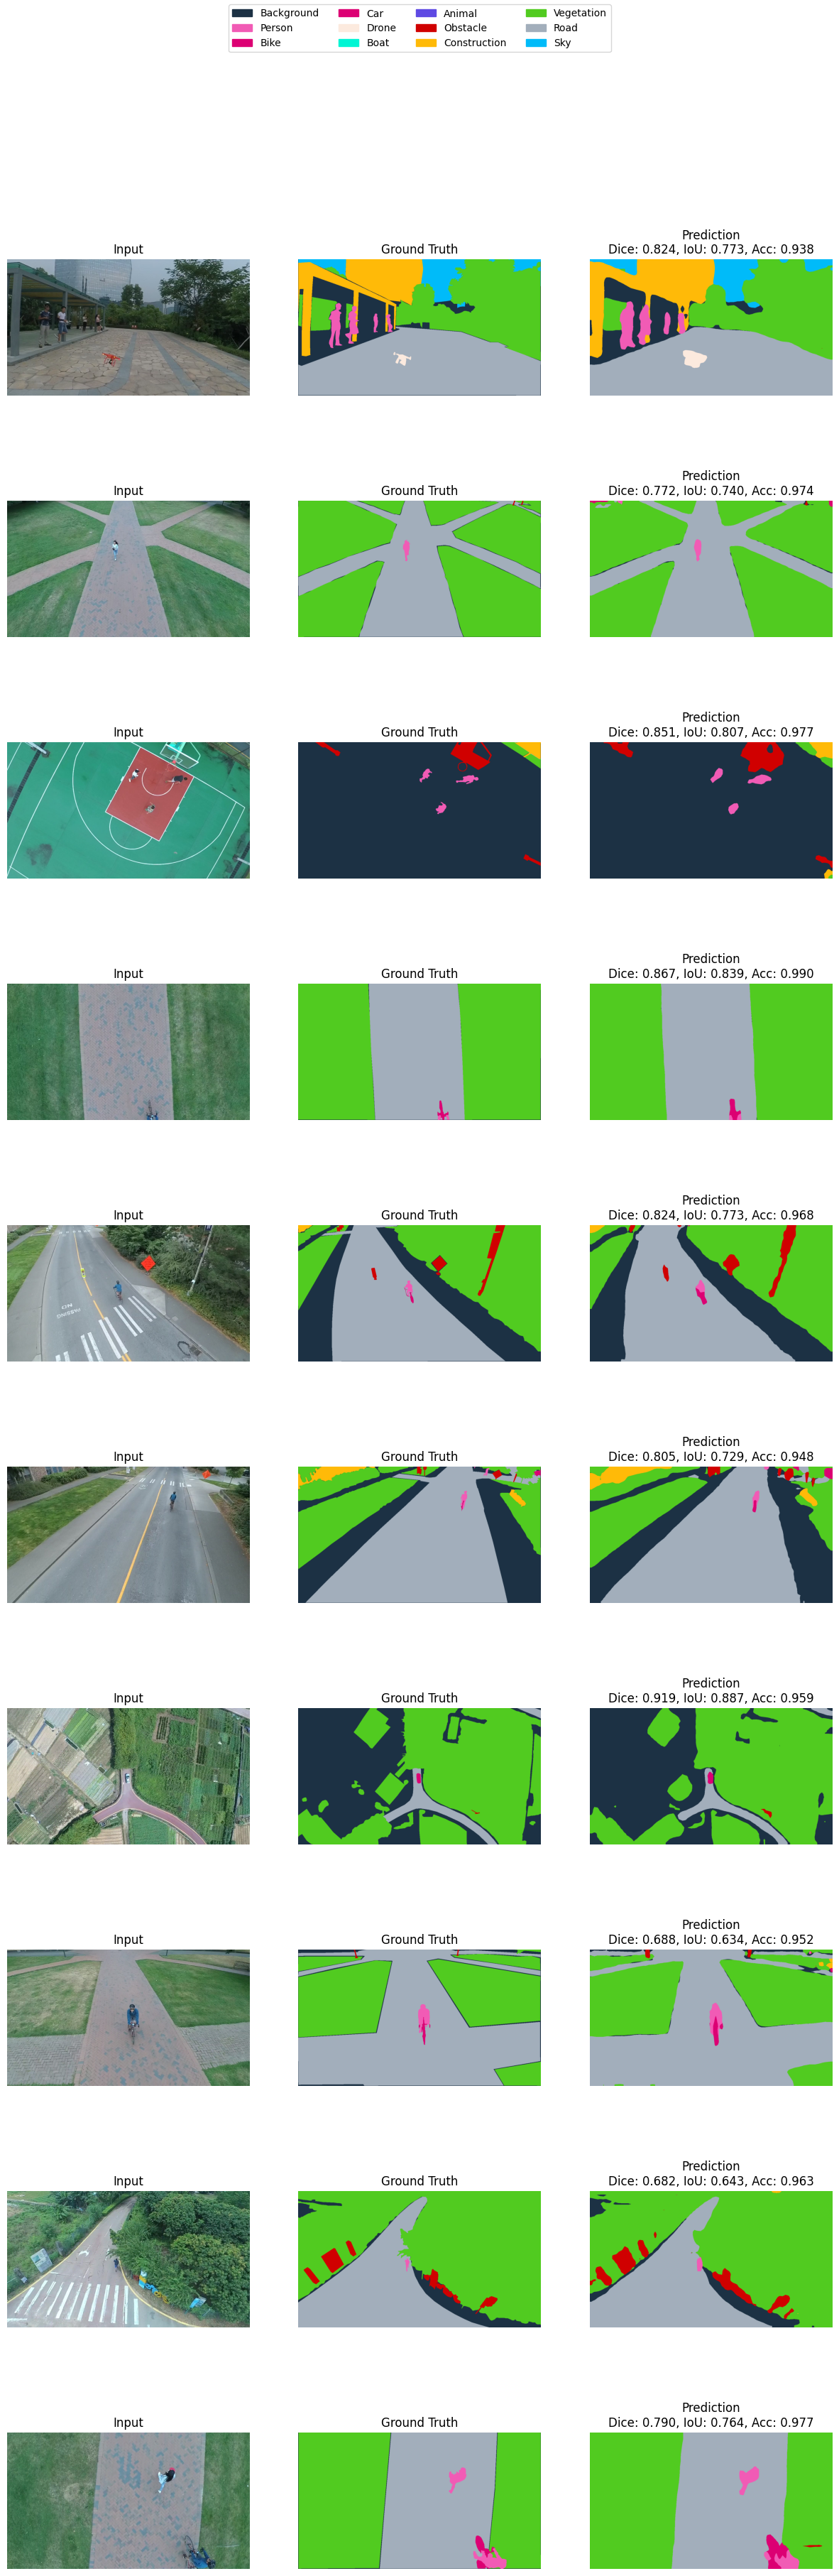

In [27]:
show_predictions_with_metrics(
    data_module = data_module,
    color_map=idmap,
    model=model,
    num_images = 10
)

## Submission CSV Generation

Encode each predicted mask into run‑length format (RLE) and write submission file.

In [ ]:
import csv

def rle_encode(mask: np.ndarray) -> str:
    """
    Run‑length encode a binary mask.

    Args:
        mask: 1D or 2D numpy array of {0,1} indicating class presence.

    Returns:
        RLE string "start length start length ...".
    """
    pixels = mask.flatten()

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def generate_submission(
    data_module,
    model: torch.nn.Module,
    num_classes: int = 12,
    output_csv: str = 'submission.csv'
) -> None:
    """
    Run model on test set, RLE‑encode each class mask, and save CSV.

    Args:
        data_module:  AerialSeg_DataModule with test_dataloader ready.
        model:        trained segmentation model.
        num_classes:  number of classes.
        output_csv:   path to write the submission file.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()
    
    loader = data_module.test_dataloader()
    rows = []

    with torch.no_grad():
        for image_ids, images in loader:
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]

            for img_id, pred_mask in zip(image_ids, preds):
                for class_id in range(num_classes):
                    #if class_id == 0:
                    #    continue
                    class_mask = (pred_mask == class_id).astype(np.uint8)
                    #if class_mask.sum() == 0:
                    #    continue
                    if class_mask.sum() == 0:
                        rle = ""
                    else:
                        rle = rle_encode(class_mask)
                    rows.append([f"{img_id}_{class_id}", rle])

    # Write CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['ImageID', 'EncodedPixels'])
        writer.writerows(rows)

    print(f"CSV saved at: {output_csv}")


In [ ]:
generate_submission(data_module, model, output_csv='./submission.csv')

## Training Logs Legend

![Tensorboard scalars](./images/training_plots.jpg)

## Plot Legend

- **Orange**  
  Transfer learning _without_ data augmentation (only the final convolutional layer is trained).

- **Deep Blue**  
  Fine-tuning from tbe last encoder layer to output _without_ data augmentation.

- **Red**  
  Fine-tuning from the ASPP layer to output layer with data augmentation.

- **Light Blue**  
  Fine-tuning of half MobilNet layers to output layer with data augmentation.

- **Pink**  
  Fine-tuning _all_ layers with data augmentation.